In [1]:
# Imports
import cv2
import glob
import math
import pickle
import random
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip

%matplotlib inline

In [2]:
# Helpers
def plot_before_after(before, after, before_title='Before', after_title='After', gray1=False, gray2=False):
    f, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(14,10))
    ax_l.axis('off')
    ax_l.set_title(before_title, fontsize=20)
    if (len(before.shape) == 3):
        ax_l.imshow(before)
    else:
        ax_l.imshow(before, cmap='gray')
        
    ax_r.axis('off')
    ax_r.set_title(after_title, fontsize=20)
    if (len(after.shape) == 3):
        ax_r.imshow(after)
    else:
        ax_r.imshow(after, cmap='gray')
    plt.show()

def plot_one(img, title='Title', gray=False):
    f, ax = plt.subplots(1, 1, figsize=(14,10))
    ax.axis('off')
    ax.set_title(title, fontsize=20)
    if (len(img.shape) == 3):
        ax.imshow(img)
    else:
        ax.imshow(img, cmap='gray')
    plt.show()


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    cp = np.copy(img)
    for line in lines:
        cv2.line(cp, (line[0], line[1]), (line[2], line[3]), color, thickness)
    return cp

def plot_images(images, size, fig_size=(10, 10), cmap=None, titles=None):
    size_x = size[0]
    size_y = size[1]
    fig, imtable = plt.subplots(size_y, size_x, figsize = fig_size, squeeze=False)
    for j in range(size_y):
        for i in range(size_x):
            index = i + j * size_x
            if (isinstance(cmap, (list, tuple))):
                imtable[j][i].imshow(images[index], cmap=cmap[i])
            else:
                im = images[index]
                if len(im.shape) == 3:
                    imtable[j][i].imshow(im)
                else:
                    imtable[j][i].imshow(im, cmap='gray')
            imtable[j][i].axis('off')
            if not titles is None:
                imtable[j][i].set_title(titles[index], fontsize=32)
    plt.show()

Vehicles: 8792
Non-vehicles: 8968


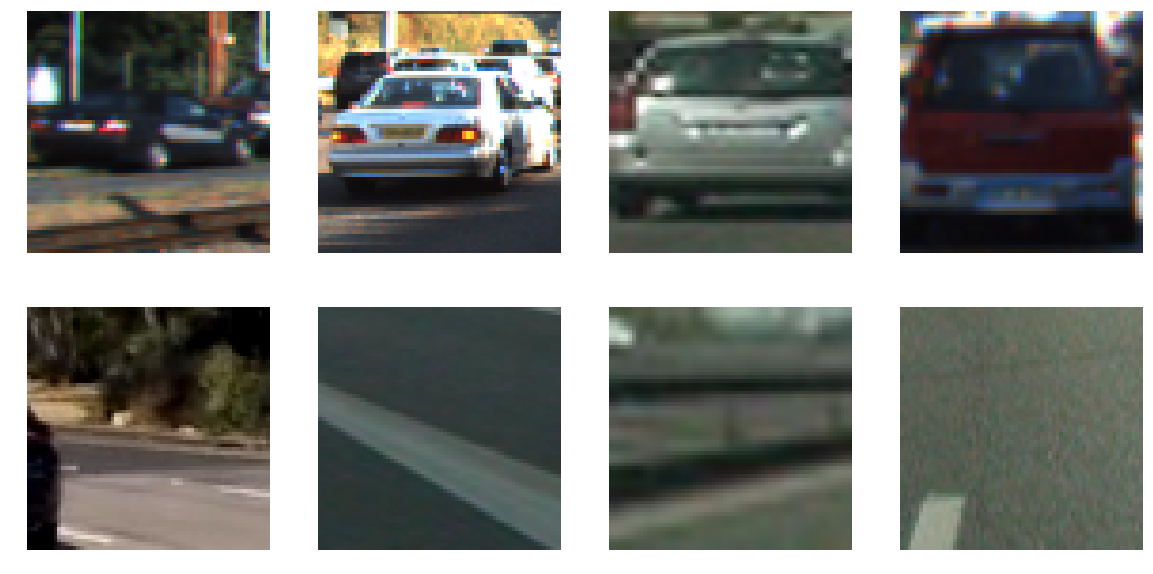

In [3]:
vehicles = []
for impath in glob.glob('data/vehicles/**/*.png', recursive=True):
    vehicles.append(mpimg.imread(impath))

non_vehicles = []
for impath in glob.glob('data/non-vehicles/**/*.png', recursive=True):
    non_vehicles.append(mpimg.imread(impath))

print('Vehicles:', len(vehicles))
print('Non-vehicles:', len(non_vehicles))

num_vehicles = len(vehicles)
num_not_vehicles= len(non_vehicles)
example_data = [
    vehicles[random.randint (0, num_vehicles - 1)],
    vehicles[random.randint (0, num_vehicles - 1)],
    vehicles[random.randint (0, num_vehicles - 1)],
    vehicles[random.randint (0, num_vehicles - 1)],
    non_vehicles[random.randint (0, num_not_vehicles - 1)],
    non_vehicles[random.randint (0, num_not_vehicles - 1)],
    non_vehicles[random.randint (0, num_not_vehicles - 1)],
    non_vehicles[random.randint (0, num_not_vehicles - 1)]
]
plot_images(example_data, (4, 2), fig_size=(20, 10))

In [4]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=16):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = cv2.cvtColor (img, getattr(cv2, 'COLOR_RGB2' + color_space))
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if color_space == 'GRAY':
            hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        elif hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor (image, getattr(cv2, 'COLOR_RGB2' + color_space))
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if color_space == 'GRAY':
                hog_features = get_hog_features(feature_image, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            elif hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
    
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def get_s_from_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    return hls [:,:,2]

In [5]:
# Parameters for extraction

color_space = 'GRAY' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Not For graysale!
hog_feat = True # HOG features on or off

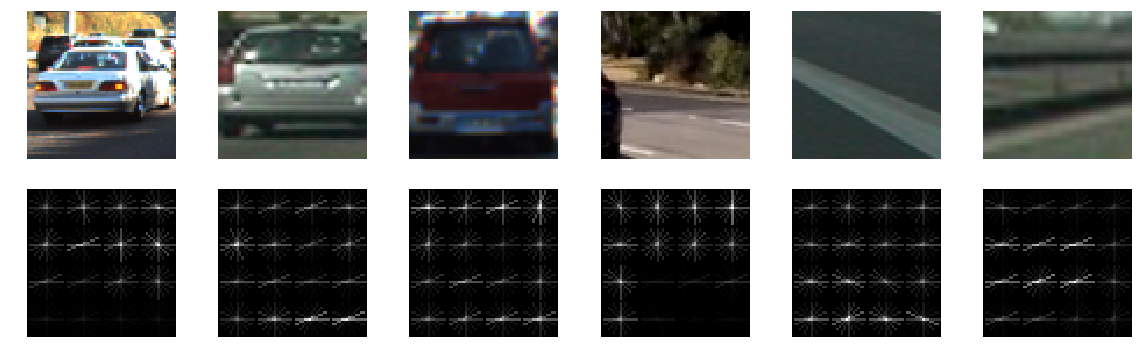

In [6]:
images_for_features = list (example_data [1:-1])

feature_examples = []
feature_examples.extend(images_for_features)

for im in images_for_features:
    features, hog_image = get_hog_features(get_s_from_hls(im), orient, pix_per_cell, cell_per_block, vis=True)
    feature_examples.append(hog_image)
    
plot_images(feature_examples, (6, 2), fig_size=(20, 6))

In [7]:
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

start = time.time()
vehicle_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
non_vehicle_features = extract_features(non_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
end = time.time()
print ('Features extraction time: ', round(end - start, 2))

X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

Features extraction time:  9.67
Feature vector length: 128


In [8]:
svc = SVC ()
svc.fit(X_train, y_train)
print('Test accuracy of SVC: ', round(svc.score(X_test, y_test) * 100, 2), "%")

Test accuracy of SVC:  98.85 %


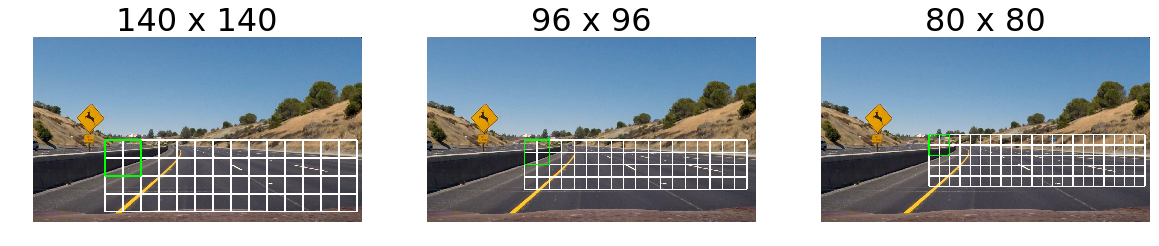

In [9]:
# Parameters for areas/windows

image = mpimg.imread('test_images/test2.jpg')
window_img = np.copy(image)

sw_x_limits =    [[280, None], [380, None], [420, None]]
sw_y_limits =    [[400, 700],  [400, 600],  [380, 580]]
sw_window_size = [(140, 140),  (96, 96),    (80, 80)]
sw_overlap = [(0.5, 0.5), (0.5, 0.5), (0.5, 0.5)]

# Set up sliding windows
windows = slide_window(image, x_start_stop=sw_x_limits[0], y_start_stop=sw_y_limits[0], 
                    xy_window=sw_window_size[0], xy_overlap=sw_overlap[0])

windows2 = slide_window(image, x_start_stop=sw_x_limits[1], y_start_stop=sw_y_limits[1], 
                    xy_window=sw_window_size[1], xy_overlap=sw_overlap[1])

windows3 = slide_window(image, x_start_stop=sw_x_limits[2], y_start_stop=sw_y_limits[2], 
                    xy_window=sw_window_size[2], xy_overlap=sw_overlap[2])

# Visualize Areas
sliding_windows = []
sliding_windows.append (draw_boxes(np.copy(image), windows, color=(255, 255, 255), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows2, color=(255, 255, 255), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows3, color=(255, 255, 255), thick=4))

# Visualize single window
sliding_windows [0] = draw_boxes (sliding_windows [0], [windows[0]], color=(0, 255, 0), thick=4)
sliding_windows [1] = draw_boxes (sliding_windows [1], [windows2[0]], color=(0, 255, 0), thick=4)
sliding_windows [2] = draw_boxes (sliding_windows [2], [windows3[0]], color=(0, 255, 0), thick=4)

sliding_window_titles = [
    '140 x 140',
    '96 x 96',
    '80 x 80'
]

plot_images (sliding_windows, (3, 1), fig_size=(20, 14), titles=sliding_window_titles)

In [10]:
def get_hot_boxes(image):
    dst = np.copy(image)
    all_hot_windows = []
    # Iterate prev sliding windows
    for x_limits, y_limits, window_size, overlap in zip(sw_x_limits, sw_y_limits, sw_window_size, sw_overlap):
        windows = slide_window(
            dst,
            x_start_stop=x_limits,
            y_start_stop=y_limits, 
            xy_window=window_size,
            xy_overlap=overlap
        )
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
        all_hot_windows.extend(hot_windows)
        dst = draw_boxes(dst, hot_windows, color=(0, 255, 0), thick=4)
    return all_hot_windows, dst
        
def update_heat_map(image, bbox_list):
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    # Iterate boxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return heatmap
    return heatmap

class AverageHotBox():
    def __init__(self, box):
        self.avg_box = [list(p) for p in box]
        self.detected_count = 1
        self.boxes = [box]
    
    def get_strength(self):
        return self.detected_count
    
    def get_box(self):
        if len(self.boxes) > 1:
            center = np.average (np.average(self.boxes, axis=1), axis=0).astype(np.int32).tolist()
            # Get all bounds
            xs = np.array(self.boxes)[:,:,0]
            ys = np.array(self.boxes)[:,:,1]
            half_width = int(np.std(xs))
            half_height = int(np.std(ys))
            return ((center[0] - half_width, center[1] - half_height), 
                    (center[0] + half_width, center[1] + half_height))
        else:
            return self.boxes[0]
    
    def is_near(self, box):
        x11 = self.avg_box[0][0]
        y11 = self.avg_box[0][1]
        x12 = self.avg_box[1][0]
        y12 = self.avg_box[1][1]
        x21 = box[0][0]
        y21 = box[0][1]
        x22 = box[1][0]
        y22 = box[1][1]
        x_overlap = max(0, min(x12, x22) - max(x11, x21))
        y_overlap = max(0, min(y12, y22) - max(y11, y21))
        area1 = (x12 - x11) * (y12 - y11)
        area2 = (x22 - x21) * (y22 - y21)
        intersection = x_overlap * y_overlap;
        if (intersection >= 0.3 * area1 or intersection >= 0.3 * area2):
            return True
        else:
            return False
        
    def join(self, boxes):
        joined = False
        for b in boxes:
            if self.is_near(b):
                boxes.remove(b)
                self.boxes.append(b)
                self.detected_count += 1
                self.avg_box[0][0] = min(self.avg_box[0][0], b[0][0])
                self.avg_box[0][1] = min(self.avg_box[0][1], b[0][1])
                self.avg_box[1][0] = max(self.avg_box[1][0], b[1][0])
                self.avg_box[1][1] = max(self.avg_box[1][1], b[1][1])
                joined = True
        return joined

def calc_average_boxes(hot_boxes, strength):
    avg_boxes = []
    while len(hot_boxes) > 0:
        b = hot_boxes.pop(0)
        hb = AverageHotBox(b)
        while hb.join(hot_boxes):
            pass
        avg_boxes.append(hb)
    boxes = []
    for ab in avg_boxes:
        if ab.get_strength() >= strength:
            boxes.append(ab.get_box())
    return boxes

In [11]:
def detect_vehicles(image, strength=2, color=(1, 1, 1), thick=4):
    hot_boxes, image_with_hot_boxes = get_hot_boxes(image)
    avg_boxes = calc_average_boxes(hot_boxes, strength)
    image_with_boxes = draw_boxes(image, avg_boxes, color, thick)
    return image_with_boxes

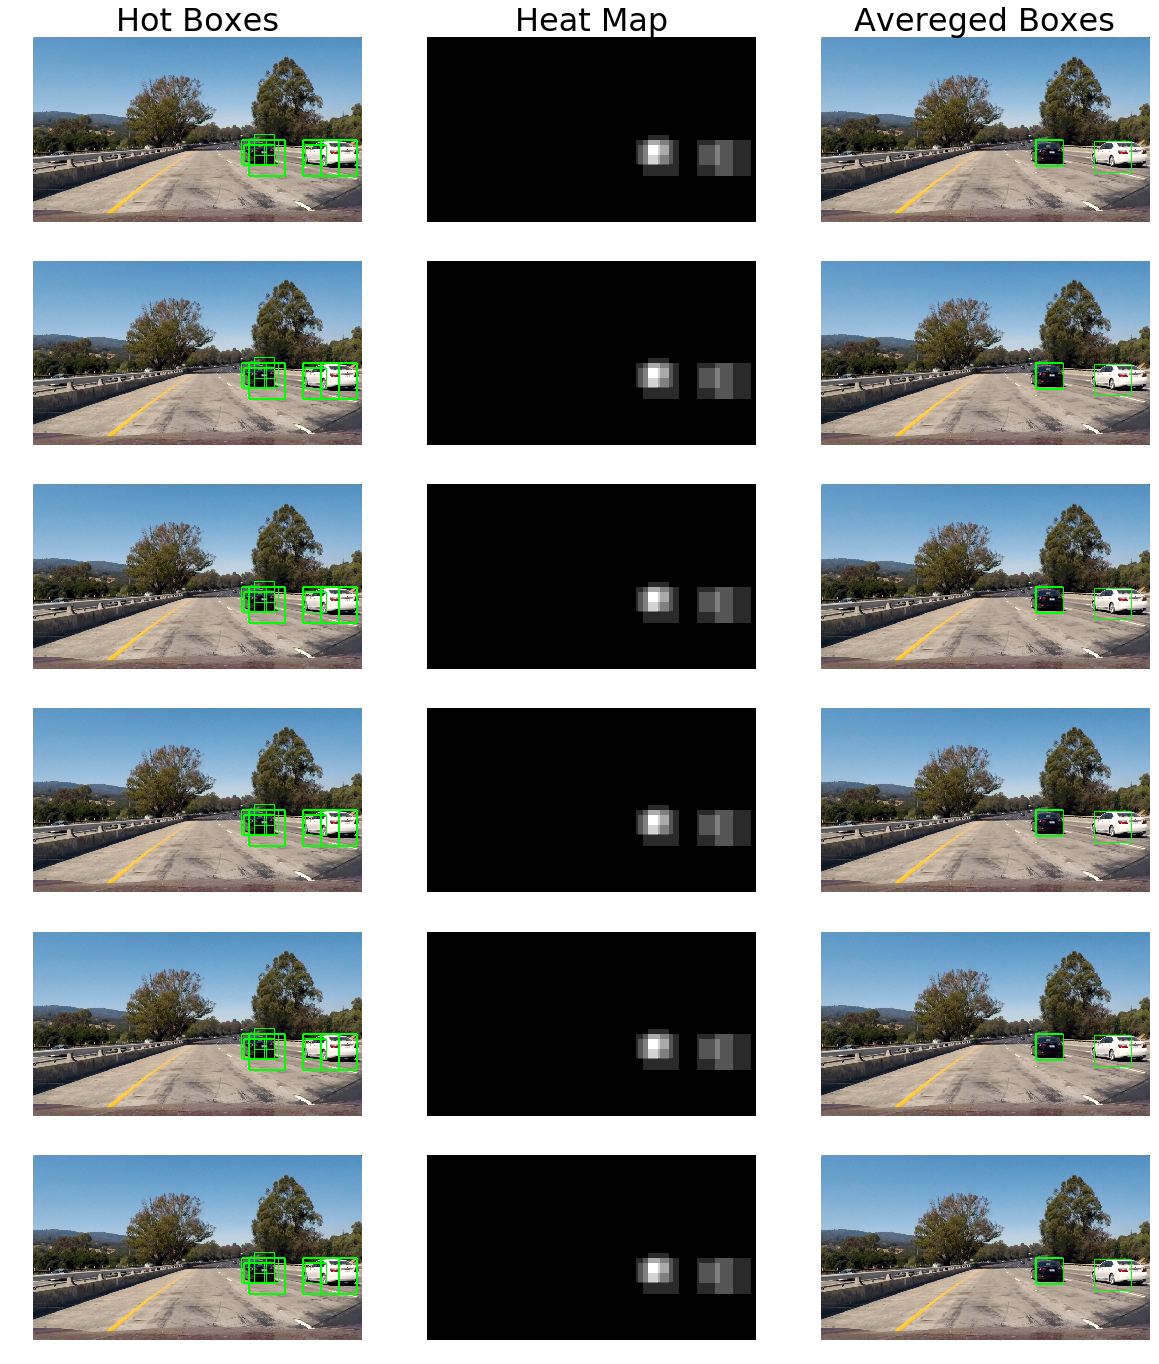

In [12]:
test_images = []
test_images_titles = []

image = mpimg.imread('test_images/test1.jpg')

for impath in glob.glob('test_images/test*.jpg'):
    image_orig = mpimg.imread(impath)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    # image = image_orig.astype(np.float32)/255

    hot_boxes, image_with_hot_boxes = get_hot_boxes(image)
    heat_map = update_heat_map(image, hot_boxes)
    
    avg_boxes = calc_average_boxes(hot_boxes, 2)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 255, 0), thick=4)
    
    test_images.append(image_with_hot_boxes)
    test_images.append(heat_map)
    test_images.append(image_with_boxes)
    
    test_images_titles.extend(['', '', ''])
    
test_images_titles[0] = 'Hot Boxes'
test_images_titles[1] = 'Heat Map'
test_images_titles[2] = 'Avereged Boxes'

plot_images(test_images, (3, 6), fig_size=(20, 24), titles=test_images_titles)

In [13]:
class LastHotBoxesQueue():
    def __init__(self):
        self.queue_max_len = 10
        self.last_boxes = []

    def set_hot_boxes(self, boxes):
        if (len(self.last_boxes) > self.queue_max_len):
            tmp = self.last_boxes.pop(0)
        self.last_boxes.append(boxes)
        
    def get_hot_boxes(self):
        b = []
        for boxes in self.last_boxes:
            b.extend(boxes)
        return b

last_hot_boxes = LastHotBoxesQueue()

In [14]:
def process_image(img_orig):
    image_orig = np.copy(img_orig)
    hot_boxes, image_with_hot_boxes = get_hot_boxes(image_orig)
    last_hot_boxes.set_hot_boxes(hot_boxes)
    hot_boxes = last_hot_boxes.get_hot_boxes()
    avg_boxes = calc_average_boxes(hot_boxes, 20)
    image_with_boxes = draw_boxes(image_orig, avg_boxes, color=(0, 255, 0), thick=4)
    image_with_vehicles = image_with_boxes
    return image_with_vehicles

def process_video(input_path, output_path):
    clip = VideoFileClip(input_path)
    result = clip.fl_image(process_image)
    %time result.write_videofile(output_path, audio=False)

process_video ('project_video.mp4', 'project_video_output.mp4')

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [04:13<00:00,  5.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 3min 56s, sys: 5.25 s, total: 4min 1s
Wall time: 4min 14s
